<a id="intro"></a>

# Kaggle Competition: House Prices - Advanced Regression Techniques

## Notebook A - Exploratory Data Anlysis and Feature Engineering

For my Udacity Data Scientist Capstone I decided to compete in the *House Prices* competition. I have been wanting to compete to in Kaggle competitions for sometime but have never really had time until recently now that I've graduated with my PhD. I had a brief 6 months to a year of (empirical/statistical) modeling experience while in graduate school but most of modeling experience I have is based on physical laws/principles and numerically solving the inevitable differential equations that arise from those laws/principles.

Well, now that I'm graduated and am able to focus on data science full-time, I really want to get my toes wet in the competitive data science scene - not to win anything, strictly just to learn. So, the namesake of this notebook is *the first* Kaggle competition I've ever competed in. In the end, I'm really pleased with how I did since this is my first competition and I used nobody else's work for inspiration. On the flip-side, I know I have a lot to learn and am excited to learn from everybody else on Kaggle. With that introduction let's get right to it.

In this notebook I will be performing the EDA and feature engineering on the data for this competition - this notebook will contain no modeling. Let's now jump to the fist key point in CRISP: Business Understanding.

### 1. CRISP-DM: Business Understanding
From Kaggle:

"Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home."

The overall goal is to predict the sale price of a home as accurately as possible, i.e, the goal is not inference. For example I can add as many features to the model as long as it increases the accuracy of the model. So my approach will be a little different than it was with my *Airbnb* project (the first project of this nanodegree). In order to accomplish this goal I will be performing feature engineering and will be using a few different machine-learning models to try and model the logarithm of **SalePrice** (in following abidement the competition rules). My guess is that XGBoost will be the highest performer and will be my final model - I have heard that XGBoost can be the standard for tabular data.

Let's now move on to the second key-point in CRISP: Data Understanding.

### 2. CRISP-DM: Data Understanding

As explained in the opening statement for this competition from Kaggle, there are 79 explanatory variables with each pertaining to a different aspect of home. The last feature is the sale price, called **SalePrice** in the dataframe, of the home - this is what I'll be predicting. The goal is to use combinations, or all, of the explanatory variables to predict **SalePrice**.

The remainder of this notebook will dedicated to the third key-point to the CRISP process: **Understanding the Data**. This is a pretty long notebook, below I provide a table of contents for easy navigation to a few points of interest.

## Table of Contents
1. [Introduction](#intro) <br>
2. [Exploratory Data Analysis](#eda)<br>
   a. [Loading the Data](#load) <br>
   b. [Duplicate Analysis](#dupe) <br>
   c. [Missingness Analysis](#miss)<br>
3. [Factor Exploration and Selection](#feat_sel)<br>
   a. [Factor Selection](#fact_sel)<br>
   b. [Feature Engineering - For factors](#fact_eng)<br>
4. [Clean the Test Data](#clean_test)<br>
5. [Covariate Exploration and Selection](#cov_expl)<br>
   a. [Covariate Selection](#cov_sel)<br>
   b. [Feature Engineering - Principal Compnent Analysis](#pca)<br>

<a id="load"></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import sklearn as sk
import pickle
import numpy as np
import visuals.plots as v

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer

dtypes = {'LotFrontage': 'double', 'LoArea': 'double',
          'MasVnrArea': 'double', 'BsmtFinSF1': 'double',
          'BsmtFinSF2': 'double', 'HeatingQC': 'category',
          'ExterQual': 'category', 'KitchenQual': 'category',
          'LotShape': 'category', 'OverallQual': 'category',
          'OverallCond': 'category', 'MSZoning': 'category'}
data_folder = 'house-prices-advanced-regression-techniques/'
training_data_name = 'train.csv'
testing_data_name = 'test.csv'
training_data_path = data_folder + training_data_name
testing_data_path = data_folder + testing_data_name
df_train = pd.read_csv(training_data_path, dtype=dtypes)
df_test = pd.read_csv(testing_data_path, dtype=dtypes)
df_train_copy = pd.read_csv(training_data_path, dtype=dtypes)
df_test_copy = pd.read_csv(testing_data_path, dtype=dtypes)
df_train.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [2]:
df_train.describe()

,Id,MSSubClass,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [32]:
df_train['SalePrice'].describe().reset_index(name='Statistics').rename(columns={'index': 'Statistic Name'})

,Statistic Name,Statistics
0,count,1460.000000
1,mean,180921.195890
2,std,79442.502883
3,min,34900.000000
4,25%,129975.000000
5,50%,163000.000000
6,75%,214000.000000
7,max,755000.000000


<a id="eda"></a>

## Exploratory Data Analysis - Data Integrity

  1. Duplicate Analysis
  2. Missingness Analysis
  3. Exploring collinearity in the dataset including with the response, SalePrice

<a id="dupe"></a>

### Duplicate Analysis

Thankfully, here are no duplicate rows in this dataset.

In [3]:
df_train.duplicated().sum()

0

In [4]:
df_train_shape = df_train.shape
print(f'The training dataset has {df_train_shape[0]:,} rows and {df_train_shape[1]:,} columns.')

The training dataset has 1,460 rows and 81 columns.


<a id="miss"></a>

### Missingness Analysis

The following features were removed due to being sparse:
  1. **PoolQC**
  2. **MiscFeature**
  3. **Fence**
  4. **Alley**
  5. **FireplaceQu**
  
In addition, the variable **Id** was removed - it will not contain any predictive signal.

This is a visual representation of a missingness matrix. White represents missing values whereas black represent a value that is not missing. From this matrix we can see that there are 4 variables that have the vast majority of their values missing. These columns will be dropped due their sparsity.

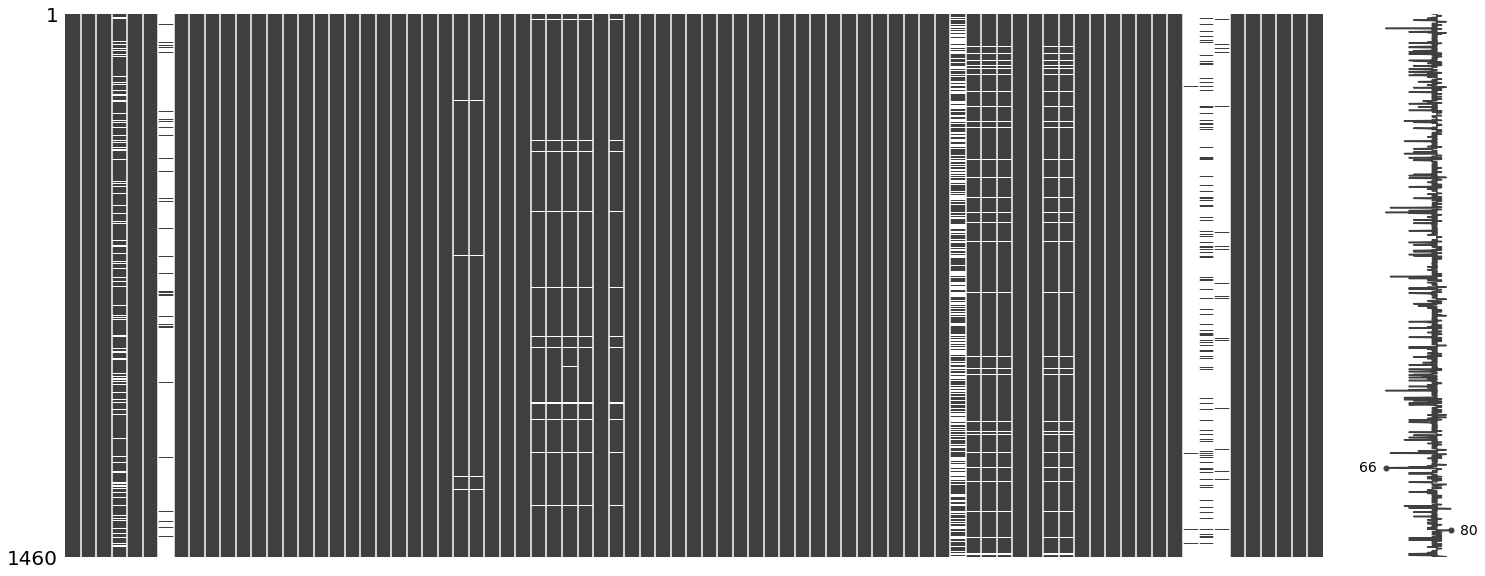

In [5]:
msno.matrix(df_train);

This is a horizontal column (bar) chart that again helps us visualize the missingness in our dataset. From this column chart we again see that there are *four* variables with the overwhelming majority of their values missing. In addition, there is one variable that has about half of its values missing; this variable will need to be investigated to see if it can engineered into something useful or it needs to be dropped (and that's if it even seem useful). The other variables look like they have a very small percentage of their values missing.

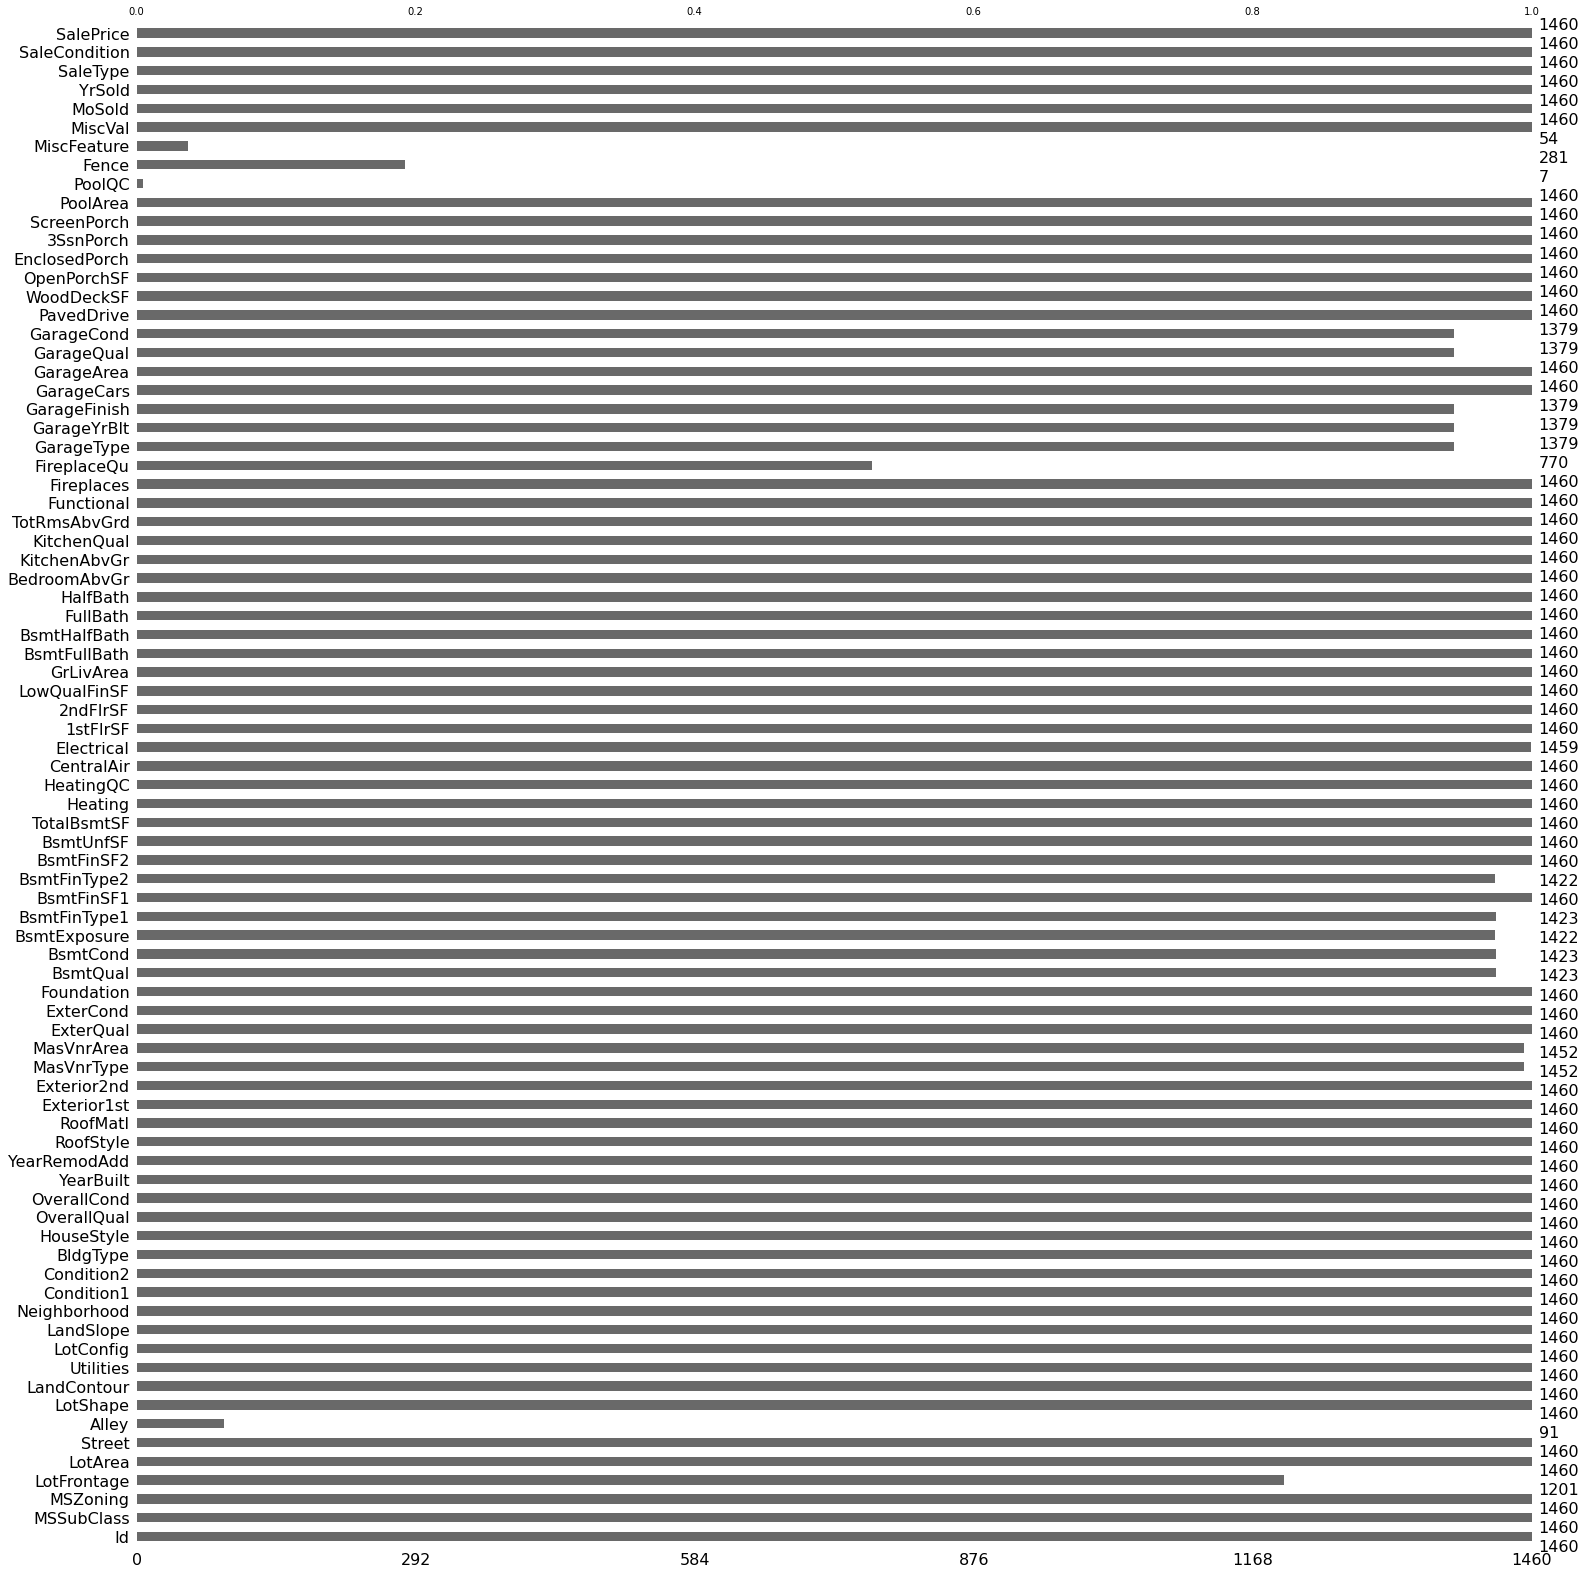

In [6]:
msno.bar(df_train);

In [11]:
missingness_perc = df_train.isnull().sum() / df_train.shape[0] * 100
cols_w_miss_vals = missingness_perc[missingness_perc > 0].reset_index(name='percent_missing')

In [16]:
cols_w_miss_vals = cols_w_miss_vals.rename(columns={'index': 'feature'})

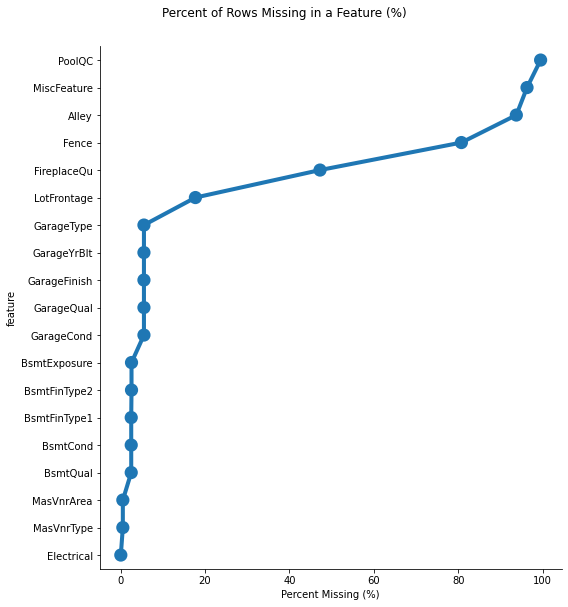

In [29]:
g = sns.catplot(
    x='percent_missing',
    y='feature',
    data=cols_w_miss_vals,
    kind='point',
    order=cols_w_miss_vals.sort_values(by='percent_missing', ascending=False)['feature'],
    height=8,
    aspect=1,
    scale=1.5
)
g.fig.suptitle(
    'Percent of Rows Missing in a Feature (%)',
    y=1.05
)
g.set(xlabel='Percent Missing (%)');

### Missingness Heatmap

This missingness heatmap tells us:
  1. That the basement variables are *not* missing at random. When one basement variable is missing, the other basement variables are almost definitely missing. The data dictionary describing this dataset indicates that an NA value indicates a property that *does not* have a basement. I will fill in missing values in all of the basement columns with 'No Basement'.
  2. The garage variables are *not* missing at random either - when one of the garage variables is missing, so are the others. This is the same issue with the basement variables. Upon further inspection of the data dictionary, I will need to follow a similar process for these (garage) variables as I have already stated for basement variables.

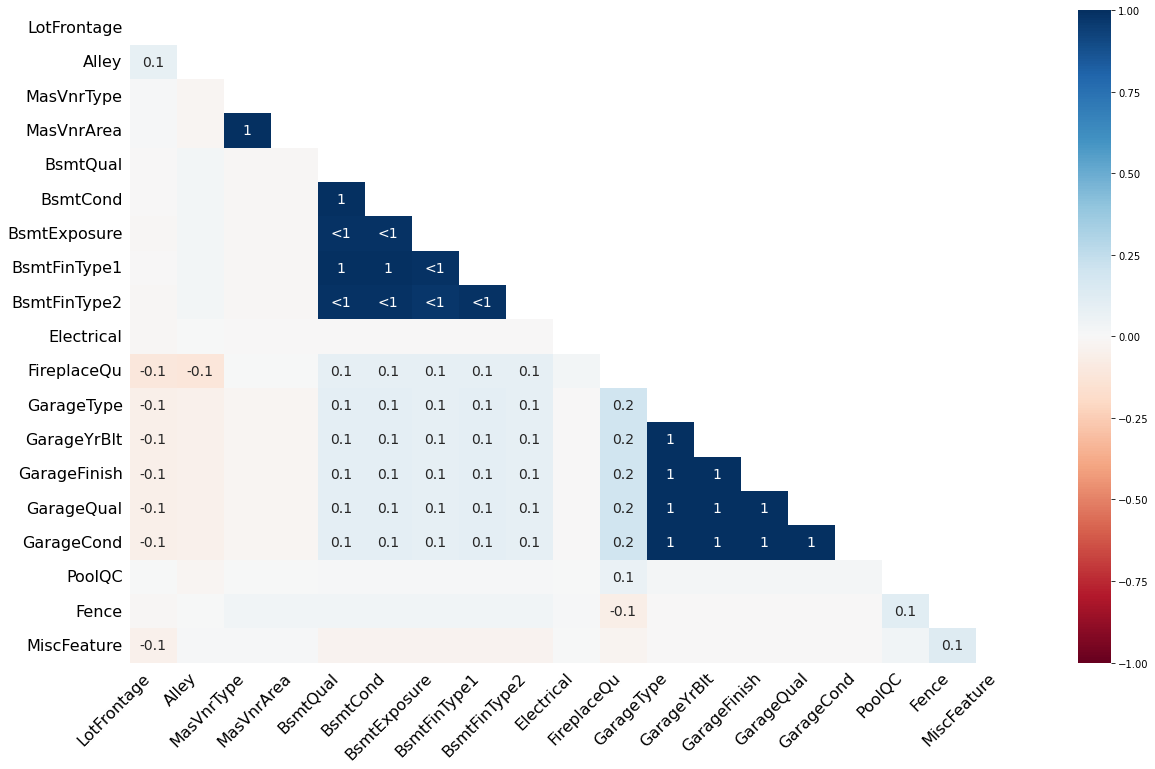

In [6]:
msno.heatmap(df_train);

### 3. CRISP-DM: Prepare Data

At this point and onward throughout this notebook I will be preparing the data for the modeling step. This includes dealing with missingness and feature engineering.

Make a new feature that calculates how many missing values were in each row.

In [7]:
df_train['NumMissVals'] = df_train.isnull().sum(axis=1)
df_train.drop(columns=['Id', 'PoolQC', 'MiscFeature', 'Fence', 'Alley', 'FireplaceQu'],
              inplace=True)

*After removing the five features mentioned at the beginning of this section, the dataset contains relatively few missing values*.

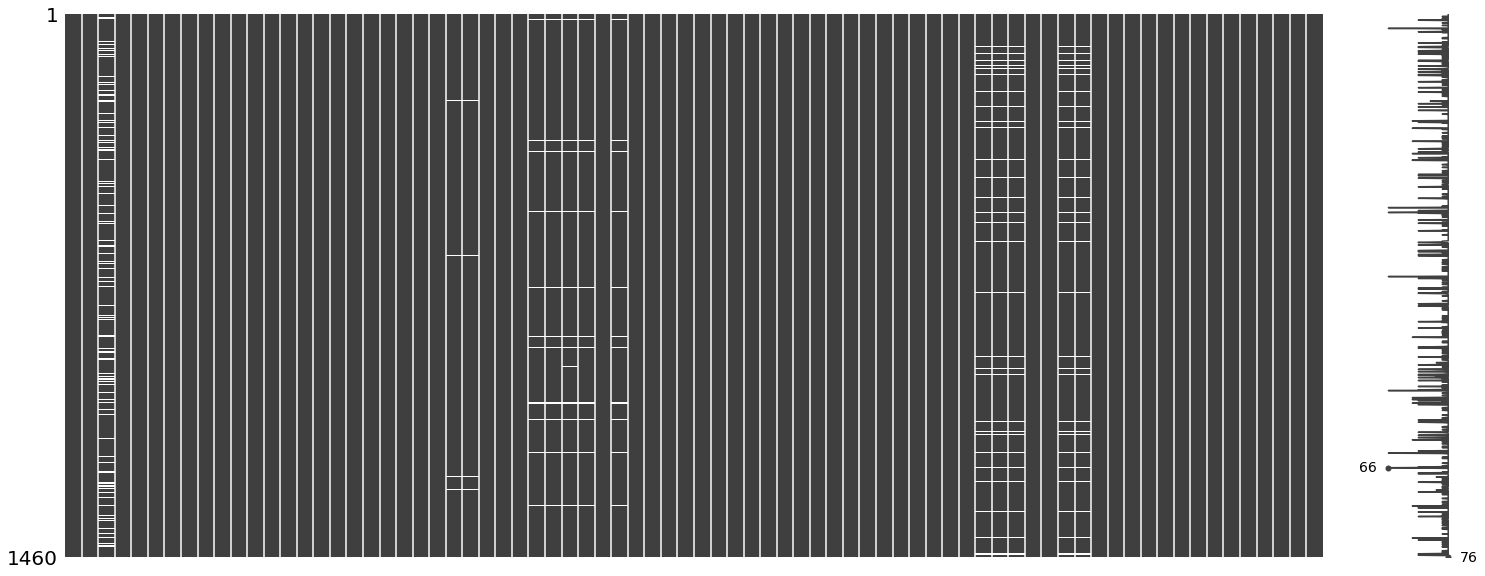

In [8]:
msno.matrix(df_train);

After removing those 5 variables the data set contains very few missing values per column. This is nicely visualized using our missingness bar chart.

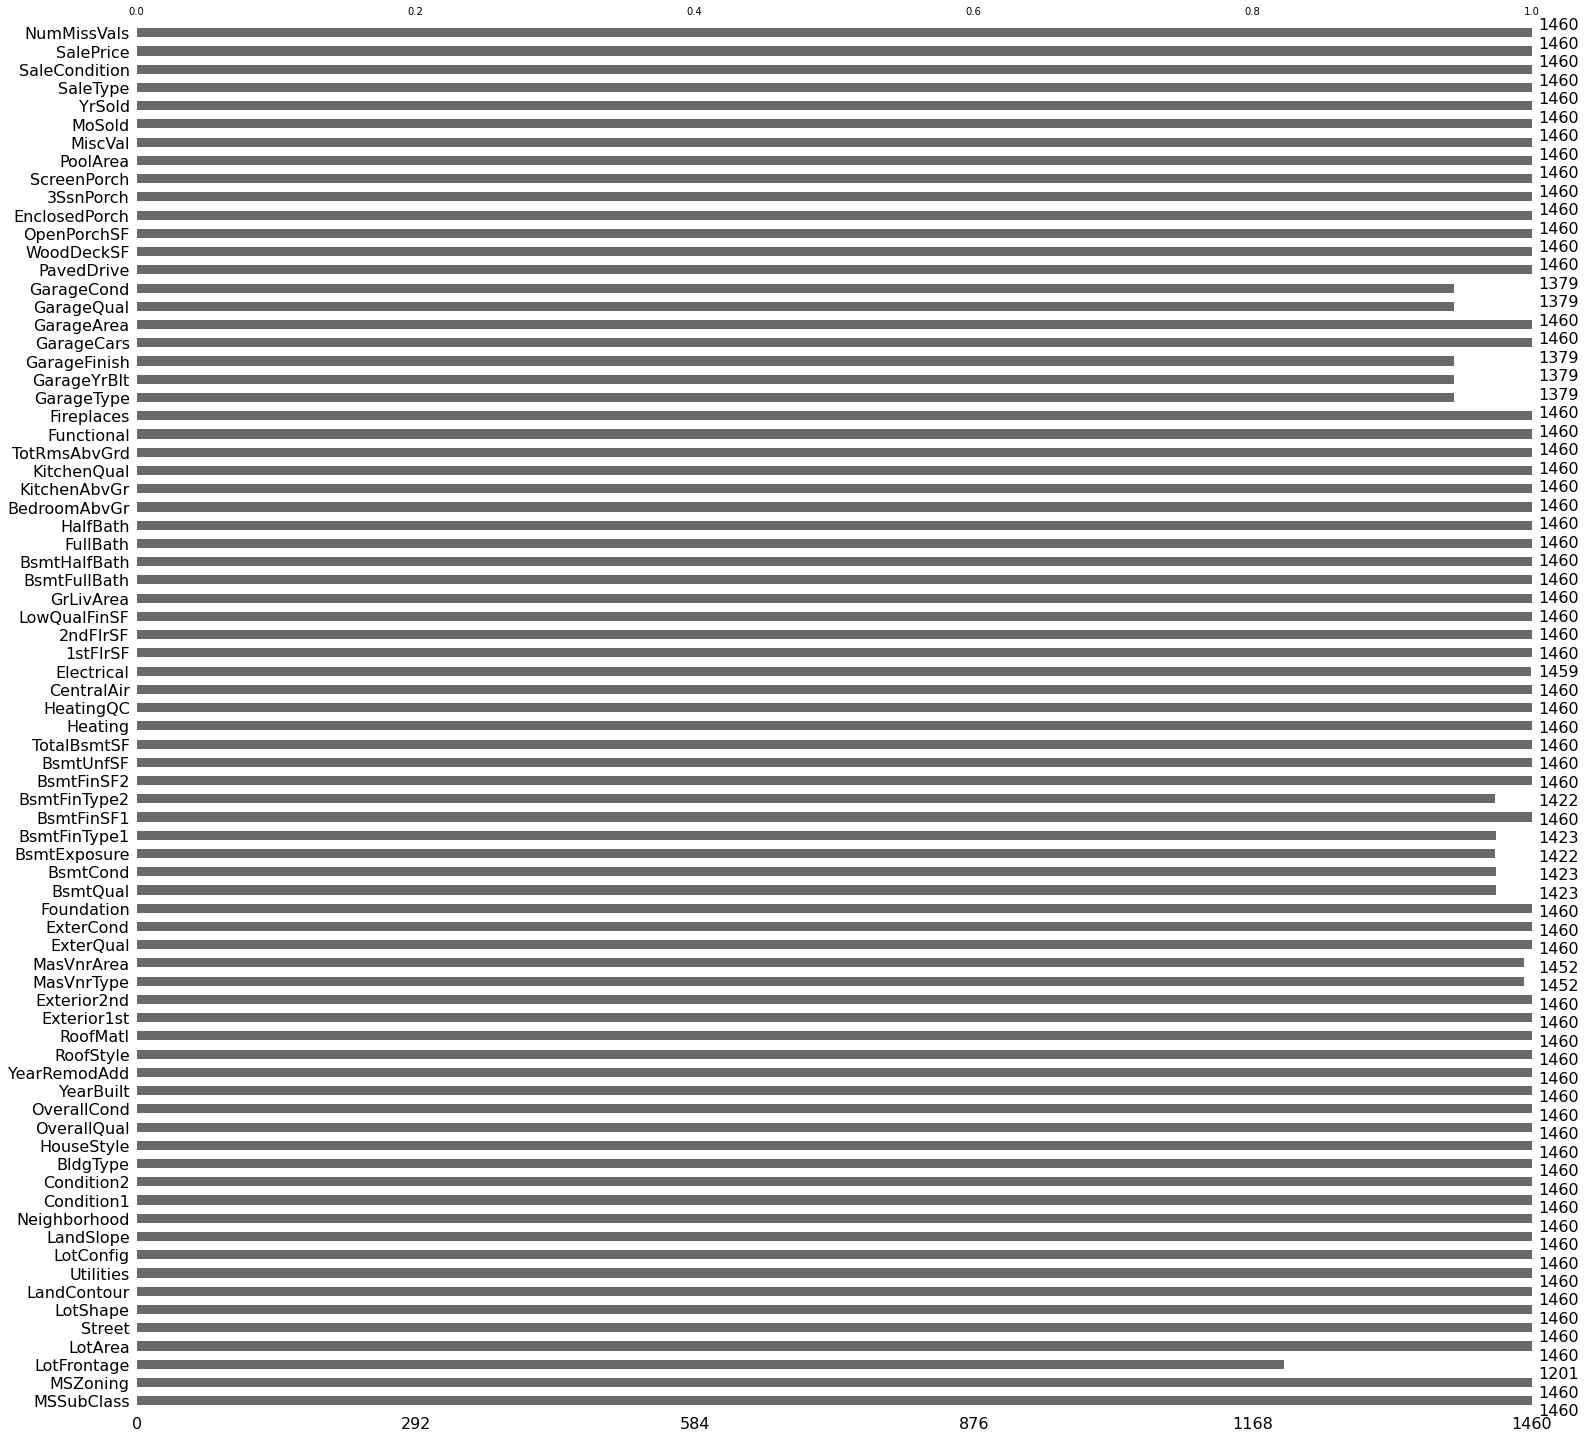

In [9]:
msno.bar(df_train);

To quanitify what we just observed in the missingness column chart, the variable with the maximum amount of missing values is **LotFrontage** and the variable with the least number of missing values (that has missing values) is **Electrical**.

In [10]:
df_train.isnull().sum()[df_train.isnull().sum() != 0]

LotFrontage     259
MasVnrType        8
MasVnrArea        8
BsmtQual         37
BsmtCond         37
BsmtExposure     38
BsmtFinType1     37
BsmtFinType2     38
Electrical        1
GarageType       81
GarageYrBlt      81
GarageFinish     81
GarageQual       81
GarageCond       81
dtype: int64

Display a histogram of the newly created feature that shows how many missing values were in each row.

This histogram shows us that overwhelming majority of rows have 3-6 missing values. In light of this, we will need to treat the issue of missingness in our dataset delicately. If we simply dropped rows where there is one or more missing values then we would dropping most of our dataset.

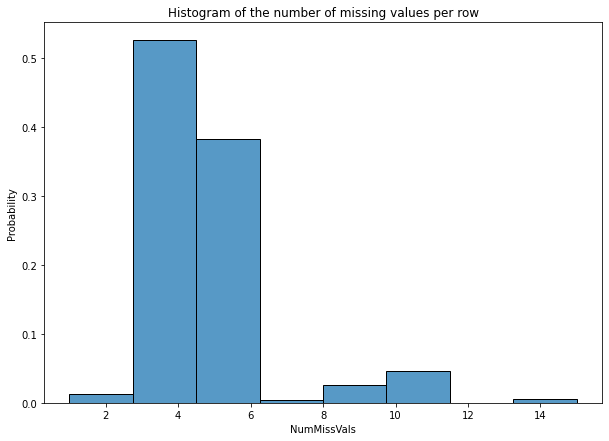

In [11]:
plt.figure(figsize=[10, 7])
g = sns.histplot(x='NumMissVals', data=df_train,
             stat='probability', bins=8)
g.set_title('Histogram of the number of missing values per row');

This concludes the sections on duplicate and missing data. In conclusion, there were several variables that were very sparse (many missing values), but upon removing these we now have a dataset where there only a few columns that have missing values. *However*, just about every row of our dataset contains missing values. Fortunately, there is a pretty easy way to fix this - for factors we can simply replace missing values with values like 'Missing' or 'No Basement' depending on the feature.

In the cell below I document the number of factors and numerical features in the dataset.

In [12]:
df_num_feats = df_train.select_dtypes(include=['int', 'double']).copy(deep=True)
df_cat_feats = df_train.select_dtypes(exclude='number').copy(deep=True)

print(f'This dataset has {df_num_feats.shape[1]:,} features that are numerical.')
print(f'This dataset has {df_cat_feats.shape[1]:,} features that are not numerical.')

This dataset has 36 features that are numerical.
This dataset has 40 features that are not numerical.


In [13]:
df_num_feats.drop(columns=['YrSold'], inplace=True)

<a id="feat_sel"></a>

## Exploratory Data Analysis - Feature Selection

Now it's time to start exploring and selecting features for our model. My goal is to select less than 20 features for my model; my purpose for selecting less than 20 features for my model is to give distance based models (like KNN) a chance against some of the other models I'm going to fit to the data.

### Feature Selection

I could spend a couple of weeks on feature selection alone and there are various methods that I could choose:

  * Filter methods using Spearman correlation for numerical features or ANOVA/Kendall's for factors.
  * Wrapper methods such as forward selection.
  
For this project, I'll keep feature selection relatively simple:
  1. I'll select numerical features based off the largest Pearson correlation with the response **SalePrice**.
  2. I'll select several factors that appear to have the most variability/predictive signal using boxplots.
 
I'll start with factors.

<a id="fact_sel"></a>

### Feature Selection - Factor Selection

I'll start out by selecting factors that I believe will have the most predictive signal of the response (**SalePrice**).

I mentioned above that I'll be using visualizations in order to select the factors that will be input into my models when I perform model selection (see the **modeling.ipynb**).

The visualizations I'll be using to select potential factors are boxplots and pointplots. Specifically, what I'm looking for are large (enough) differences in the means between the unique levels of each factor. If the means/medians between the different levels of a factor are similar to one another, then that is a strong indication that the factor under consideration will not add any value in a model predicting the response.

Using ANOVA (F-test) would certainly tell me which factors have statistically significant differences between the means of their levels, but that doesn't necessarily mean that they're practically significant. In particularly, I'm looking for large (enough, remember?) differences in the means that aren't due to a small sample size (so the level should not be too severely imbalanced in terms of sample size).

In [14]:
df_cat_feats_response = pd.concat([df_num_feats['SalePrice'], df_cat_feats], axis=1)

In [15]:
feats = np.array(df_cat_feats.columns).reshape(20, 2)
feats[0]

array(['MSZoning', 'Street'], dtype=object)

### Boxplots and Frequency Plots

Below I give boxplots between each factor and the response. Remember, I'm picking those factors that I believe have the **most** predictive signal (largest differences).

Some notable factors that look promising are:
  1. **MSZoning**: The general zoning classification of the sale.
  2. **Neighborhood**: Physical locations within Ames city limits.
  3. **ExterQual**: Evaluates the quality of the material on the exterior.
  4. **OverallQual**: Rates the overall material and finish of the house
  5. **BsmtQual**: Evaluates the height of the basement.
  6. **KitchenQual**: Kitchen Quality
  
Below I give frequency plots that display the number of samples between each level of each factor as well as boxplots between each factor and the response.

In the code cell immediately below this I give boxplots for the 38 factors present within the dataset. Note that these are strictly exploratory plots so I don't take the usual amount of care I normally do by tidying up the axes ticks, titles etc. The boxplots below are used to select variables for future exploration.

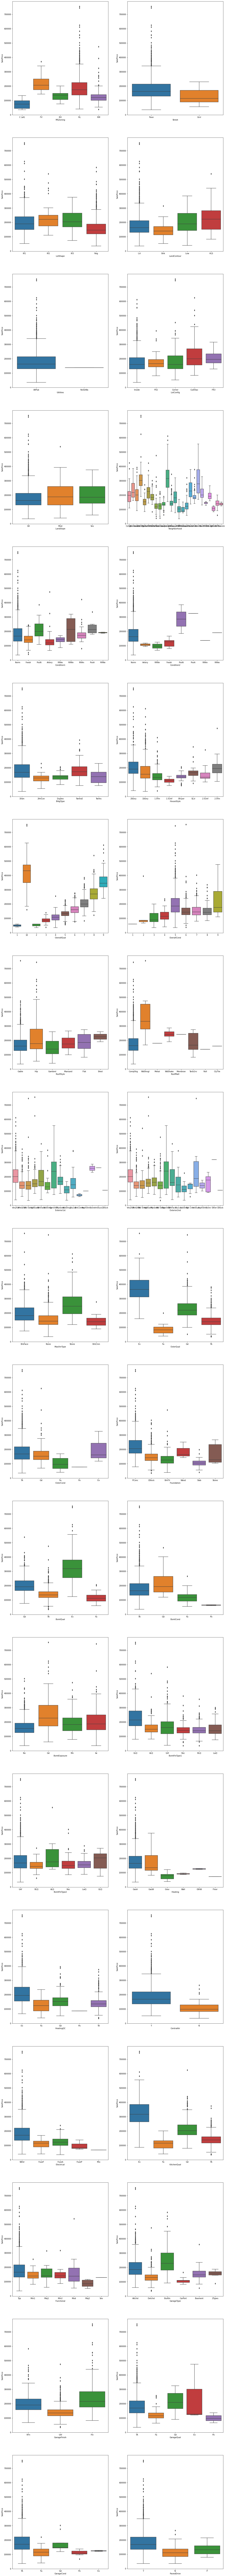

In [16]:
feats = np.array(df_cat_feats.columns).reshape(20, 2)
fig, axes = plt.subplots(19, 2, figsize=[20, 250])
first_col = 0
second_col = 1

for i in range(19):
    sns.boxplot(x=feats[i][first_col], y='SalePrice', data=df_cat_feats_response, ax=axes[i][first_col])
    sns.boxplot(x=feats[i][second_col], y='SalePrice', data=df_cat_feats_response, ax=axes[i][second_col])    

In the next six code cells I give the number of levels in each factor, for exploratory purposes.

In [17]:
df_train['Neighborhood'].nunique()

25

In [18]:
df_train['ExterQual'].nunique()

4

In [19]:
df_train['OverallQual'].nunique()

10

In [20]:
df_train['MSZoning'].nunique()

5

In [21]:
df_train['KitchenQual'].nunique()

4

In [22]:
df_train['BsmtQual'].nunique()

4

In the next three code cells I clean up the **MSZoning** variables by aggregating all of the levels with a low samples size (which is all of the levels *except* **RL**.

In [23]:
df_train['MSZoning'] = df_train['MSZoning'].str.replace(r'\(all\)', '', regex=True).str.strip()

In [24]:
df_train['MSZoning'] = df_train['MSZoning'].astype('category').cat.add_categories(['Other', 'A', 'I', 'RP'])

In [25]:
level_order = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
df_train['OverallQual'] = df_train['OverallQual'].cat.as_ordered().cat.reorder_categories(level_order)

#### Factor Selection: A Closer Look

To get a closer look at each factor that I've now (tentatively) selected, I will plot:
  1. Column charts: to show the distribution of each factor.
  2. Boxplots: to show the relation between the factor of interest and the response

The **Neighborhood** frequency plot is very imbalanced. There are 3-4 main neighborhoods that have homes that sell, but the majority of the neighborhoods have less than 100 homes that have solds. This feature has many levels, most of which are imbalanced; many of the dummy variables will contain the same information. For example, say I created a dummy variable for **Neighborhood** and the first observation is a sold property in the *NAmes* neighborhood. Well, then 23/24 of the dummy variables are telling us that this home was not bought in the other neighborhoods whereas only *one* dummy variable is telling the model that it was bought in that neighborhood. This type of problem can cause problems in certain models like linear models (which I plan on using) so this feature will need to engineered. Specifically, I plan on using a simple of form of *supervised* feature engineering to engineer this feature (see the feature engineering section).

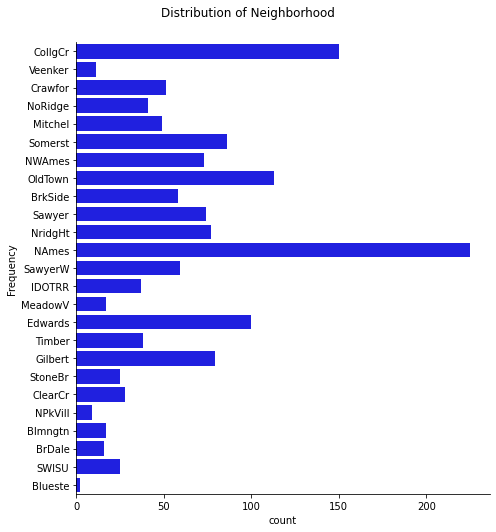

In [26]:
v.freq_plot('Neighborhood', df_train, 'blue', horizontal=True)

**MSZoning** has some severe class imbalance issues. The imbalance issues are so severe that this feature is near zero-variance feature. The 'RL' levels has the overwhelming majority of the samples. This feature will require engineering in order for it to be useful. I will likely aggregate the other levels of this feature into one 'Other' level.

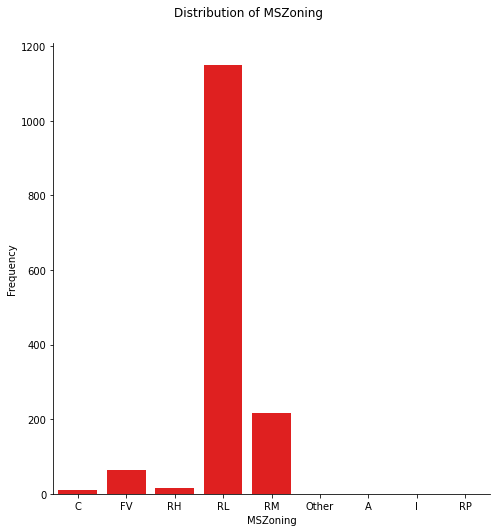

In [27]:
v.freq_plot('MSZoning', df_train, 'red')

**ExterQual** has a similar issue as **MSZoning** but not quite as severe. I will aggregate the levels for **ExterQual** into a binary variable as such:
  * ('Fa', 'TA') -> 'Bad/Typical'
  * ('Gd', 'Ex') -> 'Good/Excellent'.

This will:
  1. Solve the imbalance issue and
  2. Likely end up giving a good relationship between the response and the **ExterQual**

In [28]:
order=['Fa', 'TA', 'Gd', 'Ex']

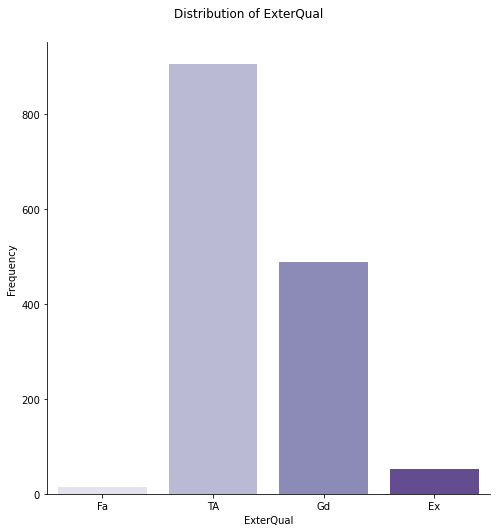

In [29]:
v.freq_plot('ExterQual', df_train, order=order, palette='Purples')

**OverallQual** is not as bad as **MSZoning** *but* I will likely break this factor into about *four* levels to account for the first three to four levels being rather sparse.

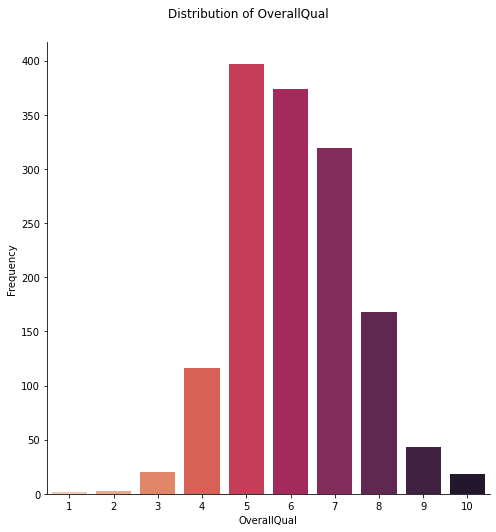

In [30]:
v.freq_plot('OverallQual', df_train, palette='rocket_r')

**BsmtQual** is at least symmetrically distributed. Fair to Typical basement qualities have about the same number of samples as Good to Excellent basement qualities. I see myself binning this variable into a binary variable for 'Bad'/'Good' basement qualities.

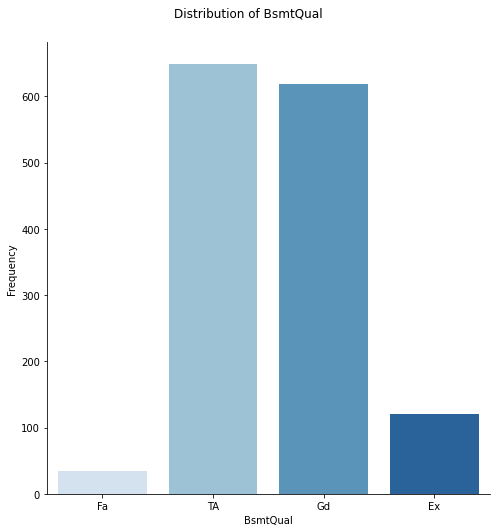

In [31]:
v.freq_plot('BsmtQual', df_train, order=order, palette='Blues')

For **KitchenQual** see my comments for **BsmtQual**.

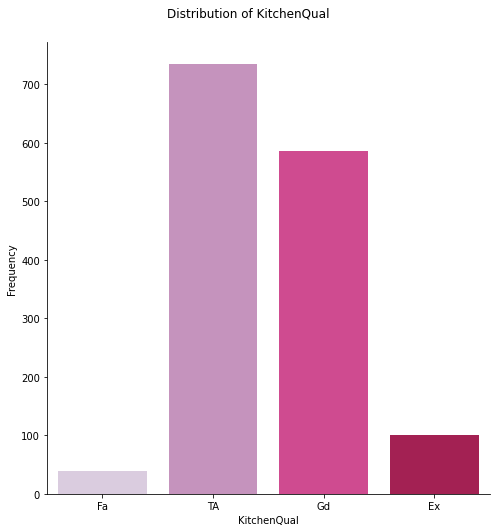

In [32]:
v.freq_plot('KitchenQual', df_train, order=order, palette='PuRd')

**GarageQual** is a near zero-variance variable. There's really nothing I can do with it. I *will not* include **GarageQual** in the model.

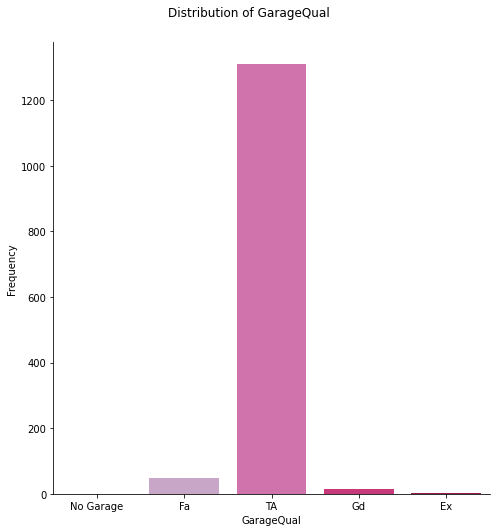

In [33]:
garage_order = ['No Garage', 'Fa', 'TA', 'Gd', 'Ex']
v.freq_plot('GarageQual', df_train, order=garage_order, palette='PuRd')

#### Column Chart Conclusion:

Each factor has class imbalance issues - most of these are easy to fix though. I've given hints as to what I will do for each factor as I've shown their frequency plots. I will *detail* what I will do for each factor in the *Feature Engineering* section.

Now, I will give boxplots to illustrate the relationship between each factor and the response, **SalePrice**.

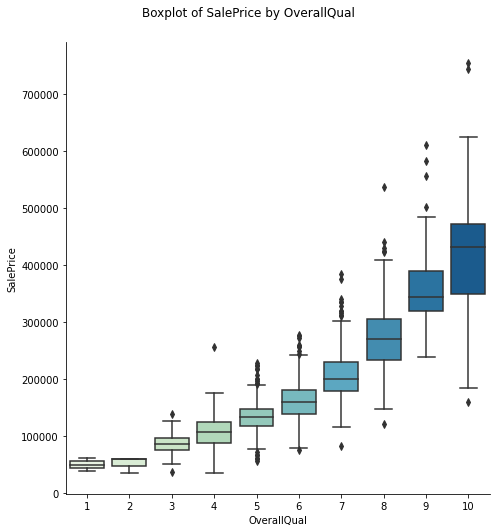

In [34]:
v.boxplots('OverallQual', 'SalePrice', df_train, palette='GnBu')

**OverallQual** has a really easily seen and interpretable relationship with the response: the higher quality material and finish of the house, the higher the price the house will sale for.

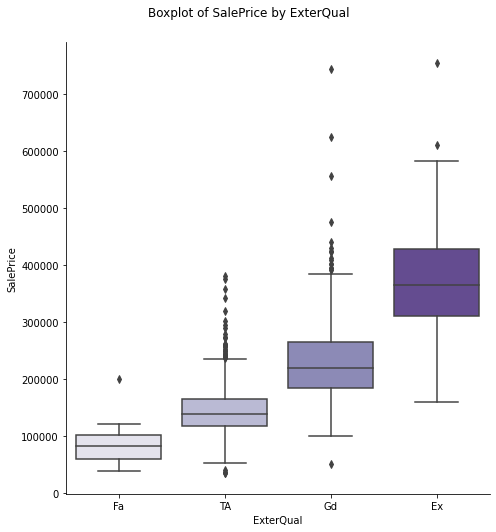

In [35]:
v.boxplots('ExterQual', 'SalePrice', df_train, order=order, palette='Purples')

**ExterQual** also has a really nice relationship with the response **SalePrice**: the higher quality of the exterior of the property, the higher the price that it sales for.

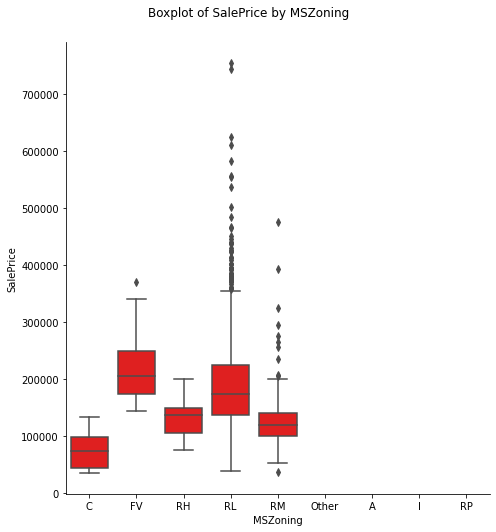

In [36]:
v.boxplots('MSZoning', 'SalePrice', df_train, 'red')

**MSZoning** has some really large differences between each level. This will should a nice feature to add to the model after some engineering is performed.

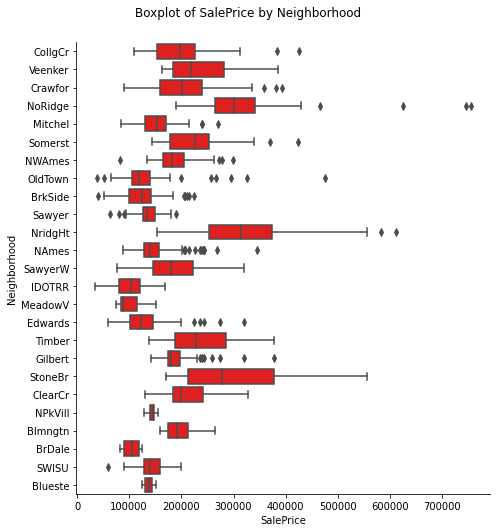

In [37]:
v.boxplots('Neighborhood', 'SalePrice', df_train, 'red', horizontal=True)

I had the highest anticipation for **Neighborhood** and it did not disappoint. There are some very large differences between just about every neighborhood. I have two different ideas for this variables one which is an unsupervised feature engineering method and the other is a supervised learning method. It's likely that the supervised method will outperform the unsupervised method, but *both* are a worth a shot.

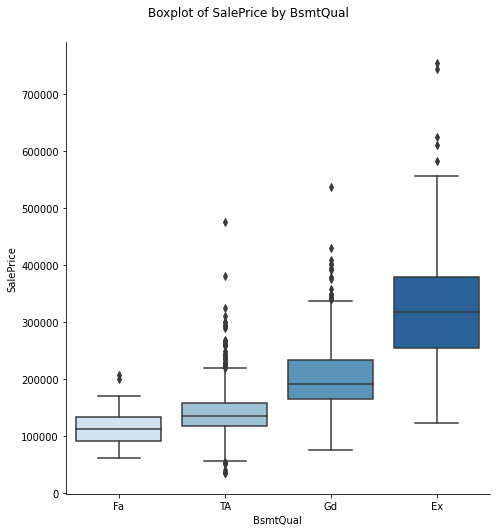

In [38]:
v.boxplots('BsmtQual', 'SalePrice', df_train, order=order, palette='Blues')

**BsmtQual** has a really nice relationship with the response (pretty big differences between each level). I believe once I solve the class imbalance issues, then **BsmtQual** should make a good addition to the model.

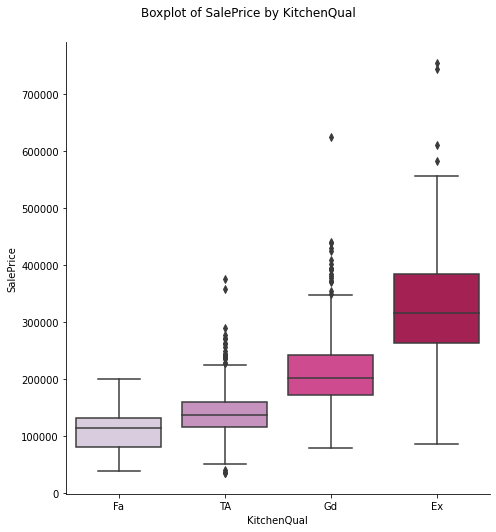

In [39]:
v.boxplots('KitchenQual', 'SalePrice', df_train, order=order, palette='PuRd')

I have the same thoughts for **KitchenQual** as I do for **ExterQual** and **BsmtQual**.

<a id="fact_eng"></a>

## Feature Engineering - For factors

Now, as I mentioned before, I want to select factors that have large differences in the mean response (**SalePrice**) that are not due to a small sample size. *But* as can be seen from the frequency plots above, *all* of the factors that I've selected have a class imbalance issue, i.e, for each factor there is maybe one or two levels that have most of the samples, the remaining levels have either very few or zero samples associated with them.

In order to overcome this issue I will aggregate (combine) some of the levels. I will explain the process briefly for each factors because each feature engineering task varies by each feature.

I explicitly give the high-level engineering goal for each factor:


  1. **MSZoning**: Reduce to two levels.
  2. **ExterQual** Reduce to two levels based on bad/good quality ratings.
  3. **Neighborhood**: Reduce to quartiles supervised by **SalePrice**.
  4. **OverallQual**: Reduce to three levels.
  4. **BsmtQual**: Reduce to two levels based on bad/good quality ratings.
  5. **KitchenQual**: Redue to two levels based on bad/good quality ratings.
  6. **GarageQual**: This variable was too imbalanced, I decided not to keep this factor.

In [40]:
df_train['LogSalePrice'] = np.log(df_train['SalePrice'])

Below I engineer **MSZoning**. What I decided to do was reduce **MSZoning** down to *two* levels, i.e, 'RL' and 'Other'. 'RL' had the most samples whereas the other levels (combined) accounted for less than 25%.

In [41]:
mszoning_props = df_train['MSZoning'].value_counts(normalize=True)
mszoning_mask = df_train['MSZoning'].isin(list(mszoning_props[mszoning_props > 0.2].index))
df_train['MSZoning'] = df_train['MSZoning'].mask(~mszoning_mask, other='Other')
df_train['MSZoning'].value_counts(normalize=True)

RL       0.788356
Other    0.211644
C        0.000000
FV       0.000000
RH       0.000000
RM       0.000000
A        0.000000
I        0.000000
RP       0.000000
Name: MSZoning, dtype: float64

In [42]:
mszoning_props_test = df_train['MSZoning'].value_counts(normalize=True)
levs_to_remove = list(mszoning_props_test[mszoning_props_test < 0.01].index)

In [43]:
mszoning_props_test

RL       0.788356
Other    0.211644
C        0.000000
FV       0.000000
RH       0.000000
RM       0.000000
A        0.000000
I        0.000000
RP       0.000000
Name: MSZoning, dtype: float64

In [44]:
levs_to_remove

['C', 'FV', 'RH', 'RM', 'A', 'I', 'RP']

In [45]:
df_train['MSZoning'] = df_train['MSZoning'].cat.remove_categories(levs_to_remove)

In [46]:
df_train['MSZoning'].value_counts()

RL       1151
Other     309
Name: MSZoning, dtype: int64

In [47]:
df_train['MSZoning'].value_counts(normalize=True)

RL       0.788356
Other    0.211644
Name: MSZoning, dtype: float64

Now **MSZoning** is a lot better interms of its class imbalance. *It's not great, but it's surely better the way it originally was*.

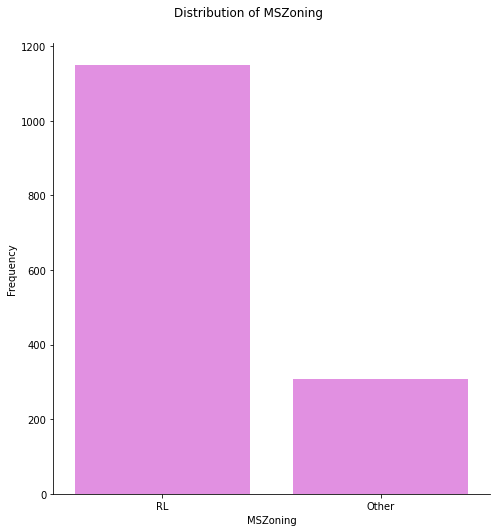

In [48]:
v.freq_plot('MSZoning', df_train, 'violet')

One thing you always have to watch out for is ruining the relationship that exists between the levels of your factor and the response. What this means is that the group ('RL' and 'Other') means are similar. In the case for **MSZoning**, this is not the case, the means are pretty different. So this factor is definitely usable in my final model.

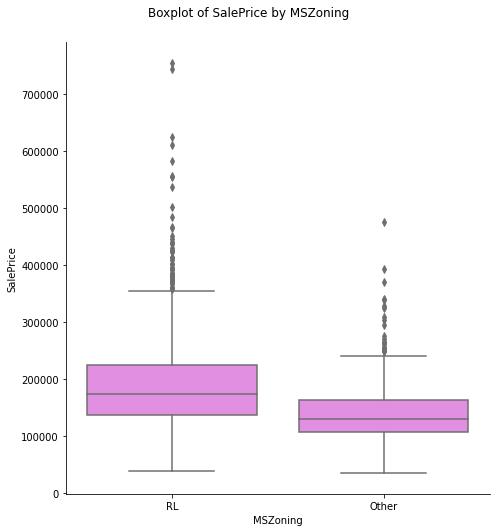

In [49]:
v.boxplots('MSZoning', 'SalePrice', df_train, 'violet')

Below I perform the feature engineering tasks for **ExterQual**.

The goal here is to reduce this factor from *five* levels ('Po', 'Fa', 'TA', 'Gd', 'Ex') to two levels ('Bad/Typical' and 'Good/Excellent). This way I'm really maintaing the original meaning of this variable but in a way that doesn't make the factor so imbalanced (there just aren't many poor and excellent quality ratings).

In [50]:
df_train['ExterQual'] = df_train['ExterQual'].cat.add_categories(['Po', 'Bad/Typical', 'Good/Excellent'])
df_train['ExterQual'] = df_train['ExterQual'].cat.as_ordered().cat.reorder_categories(['Bad/Typical', 'Po', 'Fa', 'TA', 'Gd', 'Ex', 'Good/Excellent'])

In [51]:
df_train['ExterQual'].value_counts(normalize=True)

TA                0.620548
Gd                0.334247
Ex                0.035616
Fa                0.009589
Bad/Typical       0.000000
Po                0.000000
Good/Excellent    0.000000
Name: ExterQual, dtype: float64

In [52]:
exterqual_mapper = {'Fa': 'Bad/Typical', 'TA': 'Bad/Typical',
                    'Gd': 'Good/Excellent', 'Ex': 'Good/Excellent'}
df_train['ExterQual'] =df_train['ExterQual'].replace(exterqual_mapper).astype('category').cat.reorder_categories(['Bad/Typical', 'Good/Excellent'], ordered=True)

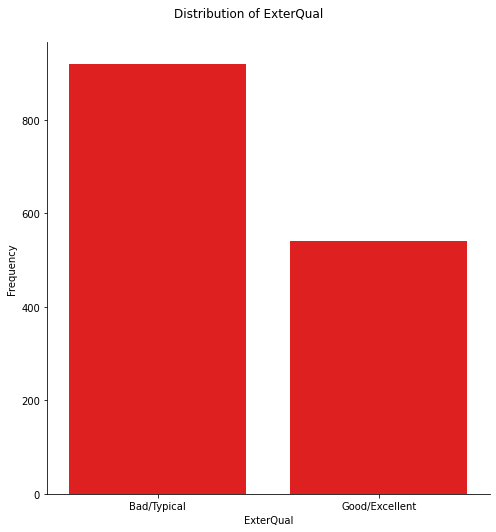

In [53]:
v.freq_plot('ExterQual', df_train, 'red')

From the output from the code cell above I've solved the imbalance issue, but now I must check to make sure that I haven't ruined the relationship between the factor and response. If we look at the boxplots (below), then we can see that I haven't. There is a large difference between the mean **SalePrice** between 'Bad/Typical' and 'Good/Excellent' quality ratings, which is great! This feature should be very usable for predicting **SalePrice**.

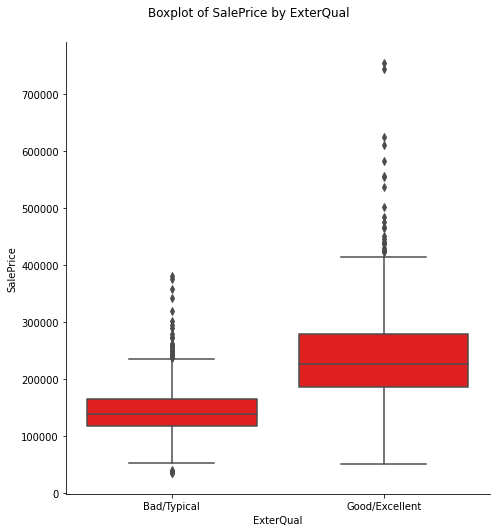

In [54]:
v.boxplots('ExterQual', 'SalePrice', df_train, 'red')

Below I perform the feature engineering tasks for **OverallQual**

In [55]:
df_train['OverallQual'].value_counts(normalize=True, sort=False)

1     0.001370
2     0.002055
3     0.013699
4     0.079452
5     0.271918
6     0.256164
7     0.218493
8     0.115068
9     0.029452
10    0.012329
Name: OverallQual, dtype: float64

In [56]:
df_train['OverallQual']

0       7
1       6
2       7
3       7
4       8
       ..
1455    6
1456    6
1457    7
1458    5
1459    5
Name: OverallQual, Length: 1460, dtype: category
Categories (10, object): ['1' < '2' < '3' < '4' ... '7' < '8' < '9' < '10']

In [57]:
overallqual_labels = ['Bad', 'Average', 'Superb']
df_train['OverallQual'] = pd.cut(df_train['OverallQual'].astype('int'),
                                 bins=[-np.inf, 4, 7, np.inf],
                                 labels=overallqual_labels).cat.as_ordered()

In [58]:
df_train['OverallQual'].value_counts(normalize=True, sort=False)

Bad        0.096575
Average    0.746575
Superb     0.156849
Name: OverallQual, dtype: float64

There still exists a class imbalance issue in this factor, however, it's *much* better than it was. If the 'Bad' level was any lower at about 8% I wouldn't probably wouldn't use this factor, but 'Bad' is right at 10% and 'Superb' accounts for over 15% of the samples in this factor, sooo, I'll keep it.

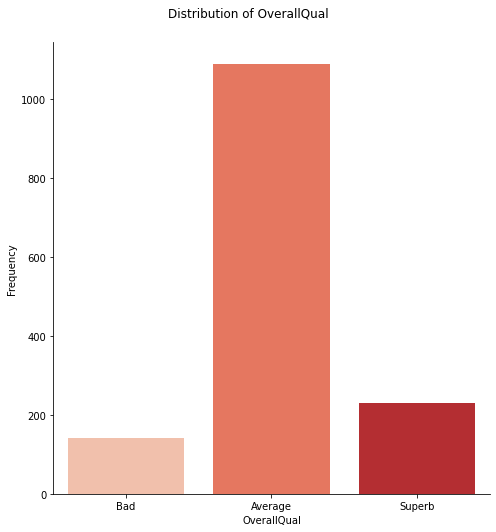

In [59]:
v.freq_plot('OverallQual', df_train, palette='Reds')

There's still a *really* nice (what looks like a super linear) relationship between **OverallQual** and **SalePrice**.

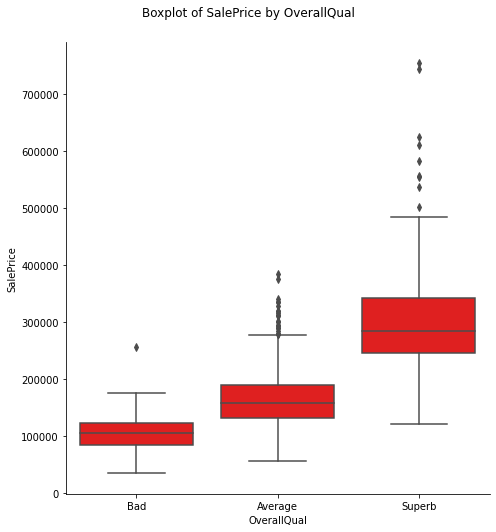

In [60]:
v.boxplots('OverallQual', 'SalePrice', df_train, 'red')

For the next few code cells I'm just going to be filling NAs - nothing exciting.

Below I'm gathering all of the basement and garage factors and counting the number of missing values in each.

In [61]:
bsmt_cols = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
garage_cols = ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']
missing_vals_bsmt = df_train[bsmt_cols].isnull().sum()
missing_vals_garage = df_train[garage_cols].isnull().sum()

In [62]:
missing_vals_bsmt

BsmtQual        37
BsmtCond        37
BsmtExposure    38
BsmtFinType1    37
BsmtFinType2    38
dtype: int64

In [63]:
missing_vals_garage

GarageType      81
GarageFinish    81
GarageQual      81
GarageCond      81
dtype: int64

In the code cell below I make mappers for the garage and basement factors.

In [64]:
bsmt_replacement_mapper = {col: 'No Basement' for col in bsmt_cols}
garage_replacement_mapper = {col: 'No Garage' for col in garage_cols}

Now I actually go through and replace all of the NA values in the basement and garage factors.

In [65]:
df_train[bsmt_cols] = df_train[bsmt_cols].fillna(value=bsmt_replacement_mapper)
df_train[garage_cols] = df_train[garage_cols].fillna(value=garage_replacement_mapper)

In [66]:
missing_vals_bsmt = df_train[bsmt_cols].isnull().sum()
missing_vals_garage = df_train[garage_cols].isnull().sum()

In the two code cells below I verify that there are no longer any missing values in the basement and garage columns.

In [67]:
missing_vals_bsmt

BsmtQual        0
BsmtCond        0
BsmtExposure    0
BsmtFinType1    0
BsmtFinType2    0
dtype: int64

In [68]:
missing_vals_garage

GarageType      0
GarageFinish    0
GarageQual      0
GarageCond      0
dtype: int64

Below I'll be performing the feature engineering tasks for **BsmtQual**. I am breaking the factor down into *three* levels: 'Bad', 'Neutral', and 'Good'.

In [69]:
bsmtqual_mapper = {'No Basement': 'Bad', 'Fa': 'Bad', 'TA': 'Neutral', 'Gd': 'Good', 'Ex': 'Good'}
df_train['BsmtQual'] = df_train['BsmtQual'].replace(bsmtqual_mapper).astype('category').cat.reorder_categories(['Bad', 'Neutral', 'Good'], ordered=True)

In the code cell below we see the column chart that gives the distribution of **BsmtQual** after the engineering tasks. This looks *much* better. There is still an imbalance between the 'Bad' level and the other levels. But the fact that I have at least two levels that account for about the same number of samples makes me feel much better - there are just very bad reviews and maybe those reviews shouldn't affect the output of the model too much.

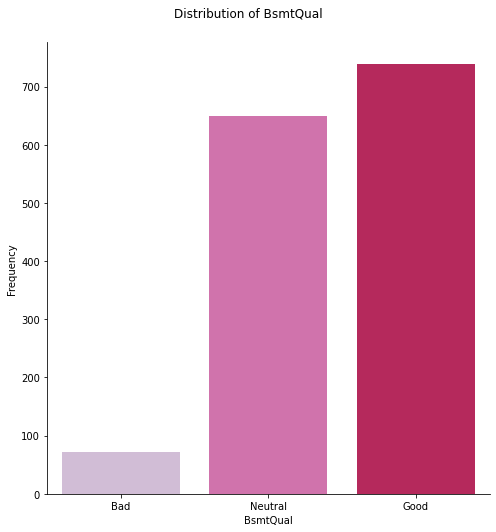

In [70]:
v.freq_plot('BsmtQual', df_train, palette='PuRd')

In the output below I now check the relationship between the newly engineered **BsmtQual** variable and the response. The relationship looks like it is still in tact, so I will definitely be keeping this variable for my model.

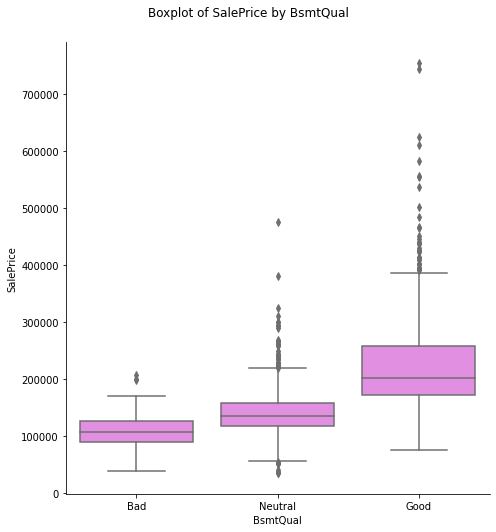

In [71]:
v.boxplots('BsmtQual', 'SalePrice', df_train, 'violet')

### KitchenQual

For **KitchenQual** I will implement the same changes I made to **ExterQual** and **BsmtQual**. I will keep **KitchenQual** as an ordinal factor and aggregate all poor to typical ratings into one level and all good-excellent ratings into another level.

In [72]:
df_train['KitchenQual'].value_counts(normalize=True, sort=True, ascending=False)

TA    0.503425
Gd    0.401370
Ex    0.068493
Fa    0.026712
Name: KitchenQual, dtype: float64

Below I build the mapper and then use the replace method to map the appropriate labels to new binary counterparts.

In [73]:
kitchenqual_mapper = {'Fa': 'Bad/Typical', 'TA': 'Bad/Typical',
                      'Gd': 'Good/Excellent', 'Ex': 'Good/Excellent'}
df_train['KitchenQual'] = df_train['KitchenQual'].replace(kitchenqual_mapper).astype('category').cat.reorder_categories(['Bad/Typical', 'Good/Excellent'],
                                                                                              ordered=True)

After making the appropriate replacements we see that **KitchenQual** is now well-balanced. I'm very happy with this result.

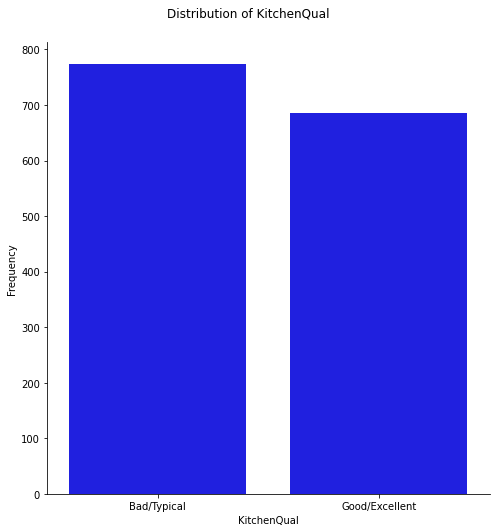

In [74]:
v.freq_plot('KitchenQual', df_train, 'blue')

This relationship is perfect. 'Good/Excellent' ratings are associated with sale prices of over \\$200,000 dollars where 'Bad/Typical' ratings are associated with median sale prices that are below \\$150,000.

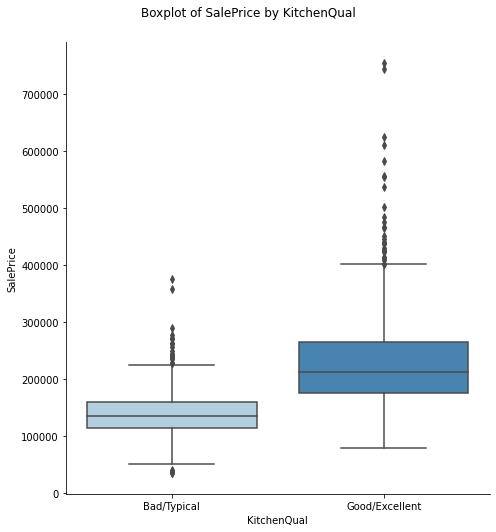

In [75]:
v.boxplots('KitchenQual', 'SalePrice', df_train, palette='Blues')

### Neighborhood - Supervised and Unsupervised Feature Engineering

Below I perform the feature engineering for **Neighborhood**. I decided to engineer this feature using two different methods. The first method I only used the factor frequency to help me engineer **Neighborhoods** - this is an example of an unsupervised method since I did not use the response, **SalePrice**. The second method I used **SalePrice** to group **Neighborhoods** into quartiles - this is a supervised method since *I did* use **SalePrice** to engineer the feature I will explain the unsupervised method first.

For this factor I decided to group the neighborhoods by sample size quartiles - neighborhoods with larger samples sizes will yield a larger quartile.

This backfired a little bit. The reason for this I believe is that there are fewer homes for sale in both low and high income neihborhood (i.e, low and highly price homes); this effectively balances the mean **SalePrice** of these two types of neighborhoods with the neighborhoods that have many homes for sale (moderately priced homes).

I think **Neighborhood** is really a key factor for predicting **SalePrice**, but for now I will just drop it. I think in the future I will either just keep **Neighborhood** the way it originally comes in the dataset or I'll figure out another way to group the neighborhoods together.

#### Neighborhoods - Unsupervised Feature Engineering Approach

First I calculate the sample size (frequency) quantiles for the different **Neighborhood**s.

In [76]:
df_train['Neighborhood'].value_counts(normalize=True, sort=True, ascending=True).cumsum()

Blueste    0.001370
NPkVill    0.007534
Veenker    0.015068
BrDale     0.026027
Blmngtn    0.037671
MeadowV    0.049315
StoneBr    0.066438
SWISU      0.083562
ClearCr    0.102740
IDOTRR     0.128082
Timber     0.154110
NoRidge    0.182192
Mitchel    0.215753
Crawfor    0.250685
BrkSide    0.290411
SawyerW    0.330822
NWAmes     0.380822
Sawyer     0.431507
NridgHt    0.484247
Gilbert    0.538356
Somerst    0.597260
Edwards    0.665753
OldTown    0.743151
CollgCr    0.845890
NAmes      1.000000
Name: Neighborhood, dtype: float64

In [77]:
neighborhood_counts = df_train['Neighborhood'].value_counts(normalize=True, sort=True, ascending=True)

I then cut the *quantiles* into *quartiles* and then make the appropriate replacements.

In [78]:
bins = [-np.inf, 0.25, 0.50, 0.75, 1.00]
labels = ['Q1', 'Q2', 'Q3', 'Q4']
neighborhood_by_quartiles = pd.cut(neighborhood_counts.cumsum(), bins=bins, labels=labels)
neighborhood_mapper = dict(neighborhood_by_quartiles)

In [79]:
df_train['NeighborhoodCountQuartiles'] = df_train['Neighborhood'].replace(to_replace=neighborhood_mapper).astype('category')

In [80]:
df_train['NeighborhoodCountQuartiles'] = df_train['NeighborhoodCountQuartiles'].cat.as_ordered().cat.reorder_categories(['Q1', 'Q2', 'Q3', 'Q4'])

This boxplot shows that grouping the neighborhoods into frequency quartiles ruins the relationship between the response and **Neighborhood** - basically all of the medians of **SalePrice** are about the same.

Next, I will use the supervised method that I described in order to make a factor (categorical feature) that will be useful in predicting **SalePrice**.

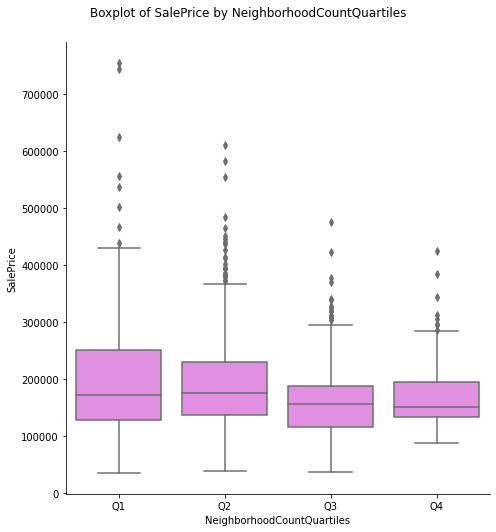

In [81]:
v.boxplots('NeighborhoodCountQuartiles', 'SalePrice', df_train, 'violet')

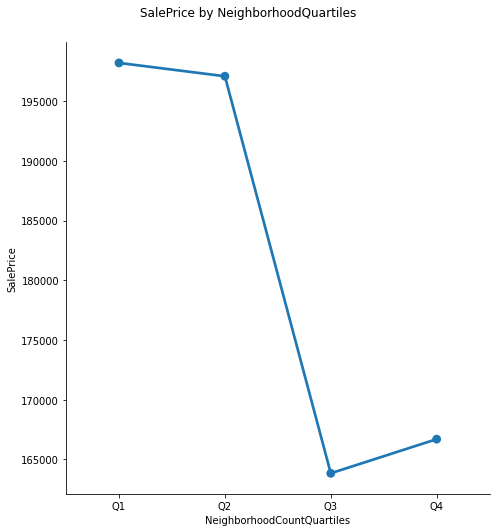

In [82]:
g = sns.catplot(x='NeighborhoodCountQuartiles', y='SalePrice', data=df_train,
              estimator=np.mean, ci=None, kind='point', height=7, aspect=1);
g.fig.suptitle('SalePrice by NeighborhoodQuartiles', y=1.05);

#### Neighborhood - Supervised Feature Engineering Approach

I will start by grouping the training dataframe by **Neighborhood** and then calculating the mean **SalePrice**. Afterwards, I sort by **SalePrice**. Then I calculate the quantiles of **Neighborhood** ordered by **SalePrice** and then quartile where each **Neighborhood** falls into.

In [83]:
neighborhood_means = df_train.groupby('Neighborhood').mean()['SalePrice'].sort_values(ascending=True).reset_index(name='MeanSalePrice')

In [84]:
mean_saleprice_quantiles = np.quantile(neighborhood_means['MeanSalePrice'], q=[0.0, 0.25, 0.5, 0.75, 1.0]).tolist()

In [85]:
neighborhood_labels = ['Q1', 'Q2', 'Q3', 'Q4']

Here I am using the Pandas.Cut function to group the quantiles into quartiles and then labeling where each **Neighborhood** falls into.

In [86]:
neighborhood_means['NeighborhoodQuality'] = pd.cut(neighborhood_means['MeanSalePrice'], bins=mean_saleprice_quantiles,
       labels=neighborhood_labels,
       include_lowest=True)

I then make a dictionary of these quartile labels.

In [87]:
neighborhood_mapper = dict(neighborhood_means.set_index('Neighborhood')['NeighborhoodQuality'])

I then make the appropriate label replacements and make a new factor, **NeighborhoodQuality**.

In [88]:
df_train['NeighborhoodQuality'] = df_train['Neighborhood'].replace(neighborhood_mapper)

**NeighborhoodQuality** is now a nicely balanced factor - all levels have close to the same number of samplels associated with them.

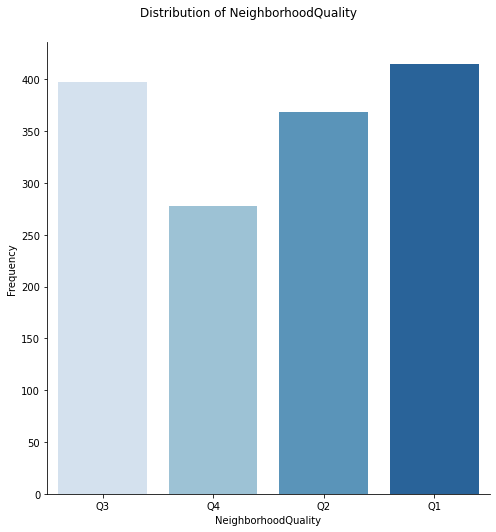

In [89]:
v.freq_plot('NeighborhoodQuality', df_train, palette='Blues')

The relationship that **NeighborhoodQuality** has with **SalePrice** is very nice - as would be expected, the response helped me to make this feature, remember?

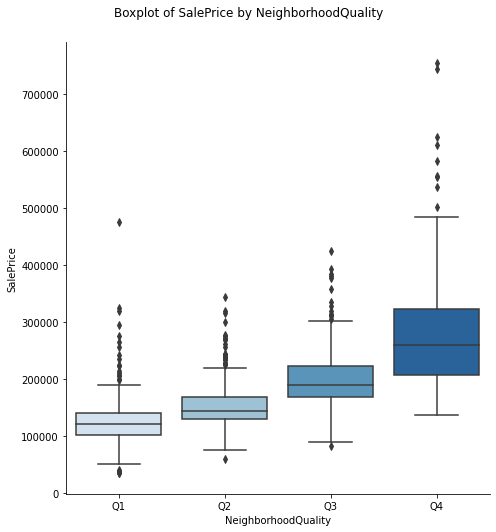

In [90]:
v.boxplots('NeighborhoodQuality', 'SalePrice', df_train, order=['Q1', 'Q2', 'Q3', 'Q4'], palette='Blues')

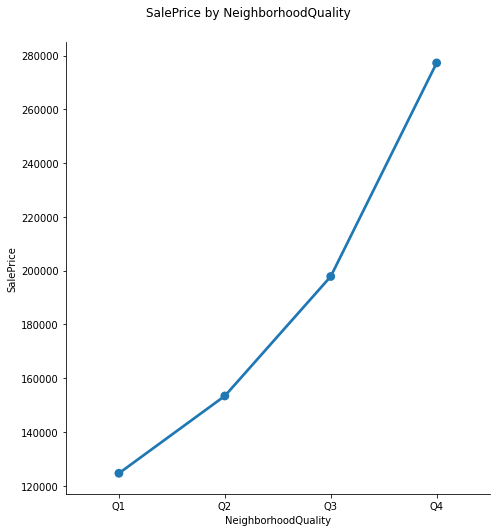

In [91]:
g = sns.catplot(x='NeighborhoodQuality', y='SalePrice', data=df_train,
              estimator=np.mean, order=['Q1', 'Q2', 'Q3', 'Q4'],ci=None, kind='point', height=7, aspect=1);
g.fig.suptitle('SalePrice by NeighborhoodQuality', y=1.05);

### Multivariate Plots - Just a few

Below I give a few multivariate plots with the response to see the newly engineered factors simultaneously relate to the response, **SalePrice**.

I use pointplots in order to avoid the clutter.

The first relationship I'll explore is between **KitchenQual**, **BsmtQual**, and **BsmtQual**.

I like the relationship between **KitchenQual**, **BsmtQual**, and **SalePrice**. The relationship between **SalePrice**, **BsmtQual**, and **KitchenQual** is intuitive to understand and the differences between the mean **SalePrice** is large enough between each level - I like it, I think these three features will make nice additions to my final model.

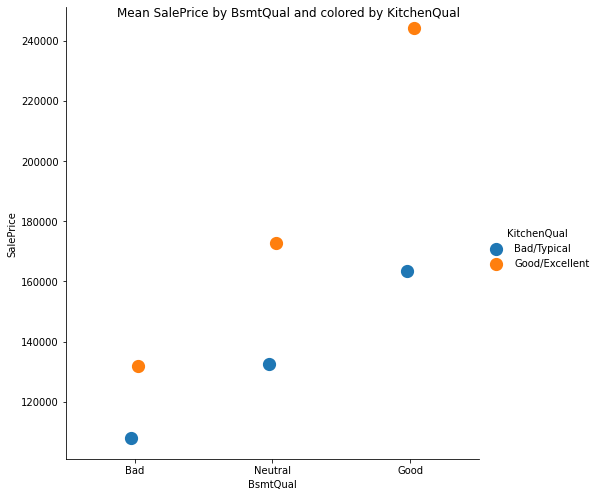

In [92]:
v.pointplots('BsmtQual', 'SalePrice', df_train, 'KitchenQual', 1.5)

I have similar comments for the relationship between **BsmtQual**, **OverallQual**, and **SalePrice** that I did for the pointplot above - these will make nice additions to my final model.

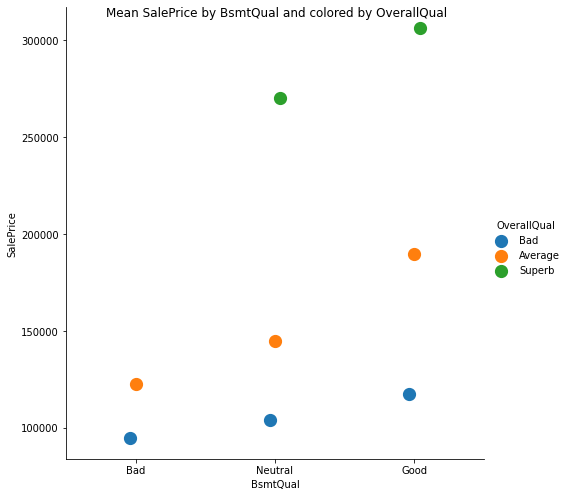

In [93]:
v.pointplots('BsmtQual', 'SalePrice', df_train, 'OverallQual', 1.5)

Again, this is a really nice relationship between these three variables; I'm happy with the work I did for engineering the factors that I chose.

In the next section I'll summarise the cleaning/feature engineering function that I'll use to make the same changes that you've just seen to the test data.

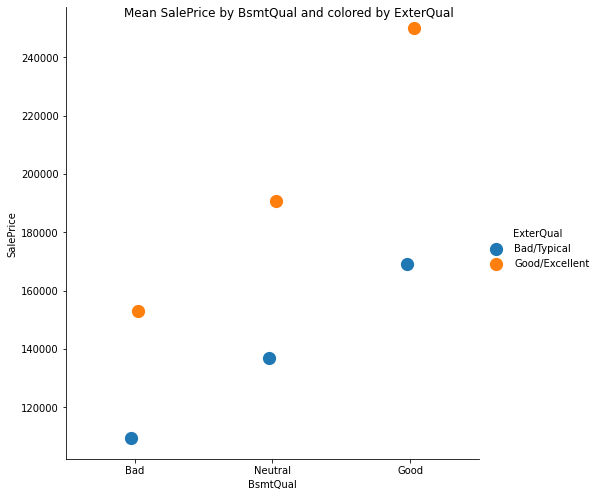

In [94]:
v.pointplots('BsmtQual', 'SalePrice', df_train, 'ExterQual', 1.5)

In [95]:
df_train['BsmtQual'].value_counts(normalize=True, sort=True, ascending=True)

Bad        0.049315
Neutral    0.444521
Good       0.506164
Name: BsmtQual, dtype: float64

In [96]:
df_train['KitchenQual'].value_counts(normalize=True, sort=True, ascending=True)

Good/Excellent    0.469863
Bad/Typical       0.530137
Name: KitchenQual, dtype: float64

<a id="clean_test"></a>

### Clean and Engineer Features in the Test Dataset

Below is a function that performs the same feature engineering on that test set that I've already performed on the training dataset.

In [97]:
def clean_data(data):
    '''Clean data on the test set for the Kaggle Housing Prices Competition
    
       Parameters:
           data: a Pandas dataframe
       Return:
           a Pandas dataframe (a copy of data) of the cleaned and engineered dataset
    '''
    data['MSZoning'] = data['MSZoning'].str.replace(r'\(all\)', '', regex=True).str.strip()
    data['MSZoning'] = data['MSZoning'].astype('category').cat.add_categories(['Other', 'A', 'I', 'RP'])
    mszoning_mask = data['MSZoning'].isin(list(mszoning_props_test[mszoning_props_test > 0.2].index))
    data['MSZoning'] = data['MSZoning'].mask(~mszoning_mask, other='Other')
    data['MSZoning'] = data['MSZoning'].cat.remove_categories(levs_to_remove)
    
    data['ExterQual'] =data['ExterQual'].replace(exterqual_mapper).astype('category').cat.reorder_categories(['Bad/Typical', 'Good/Excellent'], ordered=True)
    
    data['OverallQual'] = pd.cut(data['OverallQual'].astype('int'),
                                 bins=[-np.inf, 4, 7, np.inf],
                                 labels=overallqual_labels).cat.as_ordered()
    data['BsmtQual'] = data['BsmtQual'].fillna(list(data['BsmtQual'].mode())[0])
    data['KitchenQual'] = data['KitchenQual'].fillna(list(data['KitchenQual'].mode())[0])
    
    data['BsmtQual'] = data['BsmtQual'].replace(bsmtqual_mapper).astype('category').cat.reorder_categories(['Bad', 'Neutral', 'Good'], ordered=True)
    data['KitchenQual'] = data['KitchenQual'].replace(kitchenqual_mapper).astype('category').cat.reorder_categories(['Bad/Typical', 'Good/Excellent'],
                                                                                              ordered=True)
    data['NeighborhoodQuality'] = data['Neighborhood'].replace(neighborhood_mapper)
    return data.copy(deep=True)

For the next several code cells I'm just using the **clean_data** function to clean the test dataset and validate the data to make sure the **clean_data** does what it is supposed to. 

In [98]:
test = clean_data(df_test)

In [99]:
test['ExterQual'].value_counts(normalize=True)

Bad/Typical       0.625771
Good/Excellent    0.374229
Name: ExterQual, dtype: float64

In [100]:
test['MSZoning'].value_counts(normalize=True)

RL       0.763537
Other    0.236463
Name: MSZoning, dtype: float64

In [101]:
test['OverallQual'].value_counts(normalize=True, sort=False)

Bad        0.097327
Average    0.730637
Superb     0.172036
Name: OverallQual, dtype: float64

In [102]:
test['OverallQual'].head(3)

0    Average
1    Average
2    Average
Name: OverallQual, dtype: category
Categories (3, object): ['Bad' < 'Average' < 'Superb']

In [103]:
test['NeighborhoodQuality'].value_counts()

Q1    437
Q2    394
Q3    340
Q4    288
Name: NeighborhoodQuality, dtype: int64

In [104]:
test['KitchenQual'].value_counts()

Bad/Typical       789
Good/Excellent    670
Name: KitchenQual, dtype: int64

In [105]:
test['BsmtQual'].value_counts()

Good       728
Neutral    678
Bad         53
Name: BsmtQual, dtype: int64

In [106]:
df_train_to_save = pd.concat([df_train_copy['Id'], df_train], axis=1)

In [107]:
df_train_to_save.to_csv('train.csv', index=False)

In [108]:
df_test.to_csv('test.csv', index=False)

<a id="cov_expl"></a>

### Covariate Exploration and Selection

For the remainder of the notebook I'll focus on the numerical features (sometimes called covariates in the stats world). I'll start by analyzing the spearman correlation heatmap to pick out the features that should have the strongest relationship with the response **SalePrice**.

Once I have my numerical features selected, I will then perform a principal components analysis where I decide how many components to keep as input in to my model (next notebook).

I'll begin with analyzing the correlation heatmap.

<a id="cov_sel"></a>

### Feature Selection - Numerical Features

Now that I've applied some simple transformations to the factors (categorical features) now I need to figure what I want to do with the numerical features.

I know I want to apply PCA - the question is: how many principal components to apply? I will use a line plot of explained proportion of variance to answer this question.

Before I start calculating principal components, I need to see if PCA is necessary for this dataset - if no correlation exists between your covariates, then there is nothing to be gained by performing PCA. I am going to calculate the correlation between all of the numerical themselves and also the between the numerical features (I call these covariates sometimes) and the response **SalePrice**. This will help me pick out which features have the strongest relationship with the response.

SIDENOTE: I calculate the correlation using the [*Spearman's rank correlation coefficient*](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient). I do this because I want to understand which of the features have any kind of monotonic relationship with **SalePrice** and *not just a linear relationship*. [*Pearson's correlation coefficient*](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) is used to quanitify the linear relationship between between two numerical variables - I am looking for any monotonic relationship.

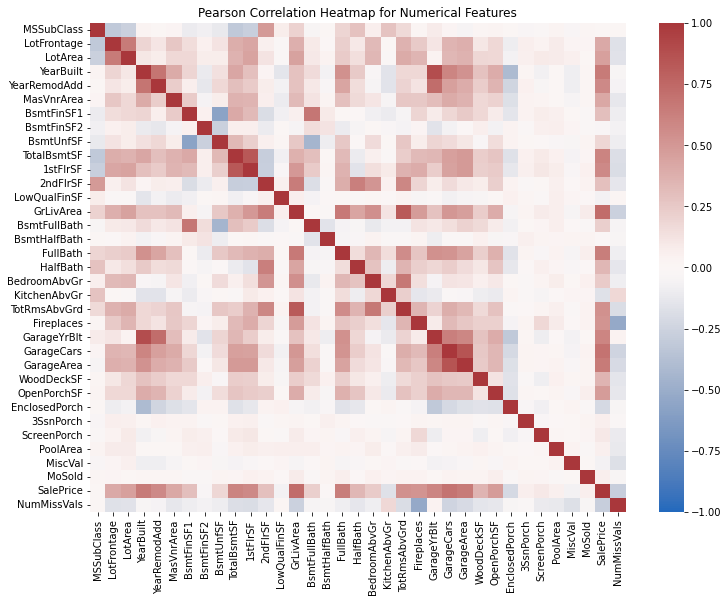

In [109]:
corr_matrix = df_num_feats.corr(method='spearman')
v.corr_heatmap(corr_matrix)

Using the correlation heatmap above, we can see that the following features seem to have a moderate to strong relationshiop with the response (SalePrice):

  1. LotFrontage
  2. LotArea
  3. YearBuilt
  4. YearRemodAdd
  5. MasVnrArea
  6. BsmtFinSF1
  7. TotalBsmtSF
  8. 1stFlrSF
  9. 2ndFLrSF
  10. GrLivArea
  11. FullBath
  12. TotRmsAbvGrd
  13. Fireplaces
  14. GarageYrBlt
  15. GarageCars
  16. GarageArea
  17. WoodDeckSF
  18. EnclosedPorch

Below I make a list of the above feature and then subset the training data by these eighteen features.

In [110]:
num_feats_to_keep = ['LotFrontage', 'LotArea', 'YearBuilt',
 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
 'GrLivArea', 'FullBath', 'TotRmsAbvGrd',
 'Fireplaces', 'GarageYrBlt', 'GarageCars',
 'GarageArea', 'WoodDeckSF', 'EnclosedPorch']

In [111]:
df_num_feats = df_train[num_feats_to_keep].copy(deep=True)

Below I plot a fresh correlation heat map between the selected covariates (excluding the **SalePrice** this time to see what degree of multicollinearity exists.

There is a moderate amount of correlation present here in this dataset. Most of the correlation coefficients hangout at about the 0.5 mark - PCA is appropriate.

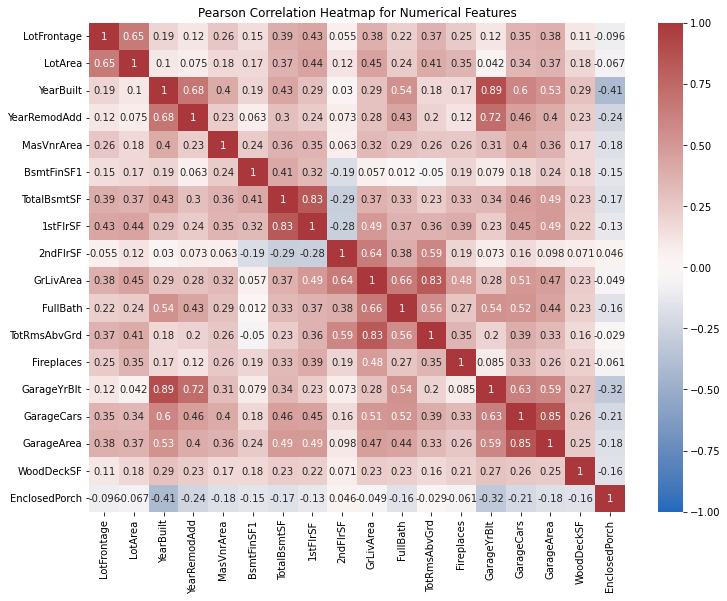

In [112]:
corr_matrix = df_num_feats.corr(method='spearman')

v.corr_heatmap(corr_matrix, True)

<a id="pca"></a>

### Feature Engineering - Principal Components Analysis

Below, I first standardize the covariates first and then calculate the PCs in order to effectively calculate the PCs from the correlation matrix. This will equal playing field for all of the covariates - features that are much larger in scale than others will have the largest coefficients in each component, i.e, will be the most important in their respective PC. By standardizing our features first, we avoid this complication.

In [113]:
pca = PCA()
scaler = StandardScaler()
scaler_fit = scaler.fit(df_num_feats)
scaled_num_feats = scaler_fit.transform(df_num_feats)
imputer = KNNImputer()
fitted_imputer = imputer.fit(scaled_num_feats)
imputed_num_feats = fitted_imputer.transform(scaled_num_feats)
pca_fit = pca.fit(imputed_num_feats)
train_scores = pca_fit.transform(imputed_num_feats)

For the next two code cells I am setting up the dataframe that I will use to plot the explained proportion of variance plot.

In [114]:
n_num_feats = imputed_num_feats.shape[1]
num_comps = [i + 1 for i in range(n_num_feats)]
num_comps = pd.Series(num_comps, name='NumComponents')

In [115]:
expl_var = pd.concat([num_comps,
           pd.Series(pca_fit.explained_variance_ratio_, name='ExplainedVarianceProportion').cumsum()],
          axis=1)

Below I give a plot of the explained proportion of variance versus the number of components. I am looking for about 80-90% of the total variance explained. From the plot below, we can see that this requires 8 principal components.

I will not add my PCs to the training data just yet. I will add the PCA object to my sci-kit learn pipeline (see modeling.ipynb), which will utilize 5-fold cross validation, to avoid data leakage into my validation datasets.

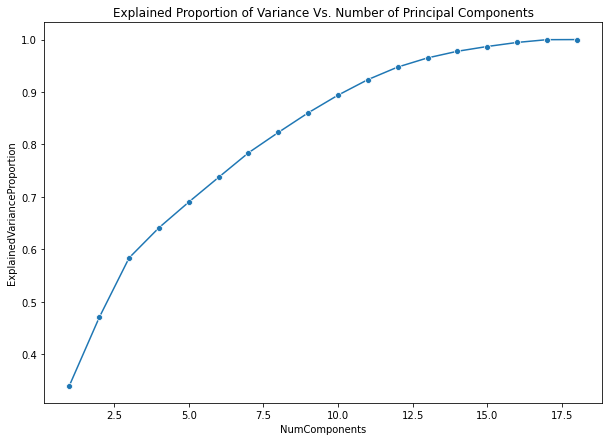

In [116]:
plt.figure(figsize=[10, 7])
g = sns.lineplot(x='NumComponents', y='ExplainedVarianceProportion', data=expl_var, marker='o')
g.set_title('Explained Proportion of Variance Vs. Number of Principal Components');

In [117]:
train_scores[:,:8].shape

(1460, 8)

In [118]:
pc_df = pd.DataFrame(train_scores[:, :8], columns=['component_1', 'component_2', 'component_3', 'component_4', 'component_5',
                                    'component_6', 'component_7', 'component_8'])

In [119]:
pc_df = pd.concat([pc_df, df_train['LogSalePrice']], axis=1)

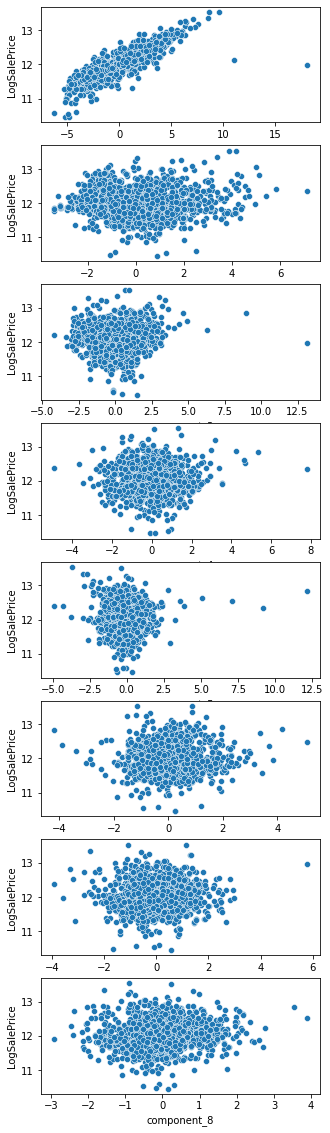

In [120]:
fig, axes = plt.subplots(8, 1, figsize=[5, 20])

for i, feature in enumerate(pc_df.columns):
    if 'LogSalePrice' in feature:
        break
    sns.scatterplot(x=feature, y='LogSalePrice', data=pc_df,
                    ax=axes[i])

This concludes my exploratory data analysis notebook. In this notebook I feel like I've accomplished a lot. I now understand my dataset and I've selected and engineered my features that I feel will be most necessary for my model predicting **SalePrice**.

In the next notebook, modeling.ipynb, I will performing model selection amonst several different machine learning models. I will use 5-fold cross validation in order to compare the different models I will be testing. I will select my final model from this comparison.